# Topic Modeling for Scholarly Community
 
Knowing what papers are talking about and understanding their problems and opinions is highly valuable. And it’s really hard to manually read through such large volumes and compile the topics. Also, it is not accurate to use keywords author wrote or simple word presence to represent  a topic, because everyone may expresess a same conception in different ways. In order to classify documents generally and adequately, we import topic modeling. 

* Discovering hidden topical patterns that are present across the collection
* Annotating documents according to these topics
* Using these annotations to organize, search and summarize texts

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s packages. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. 



<img src="tm_concept.png">


Topics are defined as sets of words related to each other. In each topic, these words have certain percentage to be choosen. Every document can be represented as a certain topic distribution.  

For example, consider the following set of documents as the corpus:

 

>Document 1: I had a peanut butter sandwich for breakfast.

>Document 2: I like to eat almonds, peanuts and walnuts.

>Document 3: My neighbor got a little dog yesterday.

>Document 4: Cats and dogs are mortal enemies.

>Document 5: You mustn’t feed peanuts to your dog.

The LDA model discovers the different topics that the documents represent and how much of each topic is present in a document. For example, LDA may produce the following results:

>Topic 1: 30% peanuts, 15% almonds, 10% breakfast… (we can interpret that this topic deals with food)

>Topic 2: 20% dogs, 10% cats, 5% peanuts… ( we can interpret that this topic deals with pets or animals)
-----------------
>Documents 1 and 2: 100% Topic 1

>Documents 3 and 4: 100% Topic 2

>Document 5: 70% Topic 1, 30% Topic 2

In this notebook, the dataset is provided by ICLS abd CSCL which are two conference organized by International Society of Learning Science, and cleaned by Stian Haklev. With some csv file from Abassi Nour Ghalia (nour.abassi@epﬂ.ch) Guillain Léonore Valentine (leonore.guillain@epﬂ.ch) this notebook use LDA to extract the naturally discussed topics.

Mainly, I use the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation. Then with the help of Dynamic Topic Model(DTL), we can see keywords weight in each topic change through years. Also the Author topic modeling(ATM) which calculate correlation between authors and topics, is also included and draw a authors' preference plot to show their cluster.


## 1. Data Preparation

### 1.1 Import Packages
There is a bunch of packages needed to import. Run the cell below.

In [1]:
# Run in python console

import ipywidgets as widgets
from IPython.display import display, HTML

import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Other setting
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhechensu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#this function is used to hide code 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
# hide_code()

### 1.2 Import data from papers
All pdf files are already converted to txt files in 'data/papers' folder.

We get a list `contents` as output which has textual data of each pdf. Then tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether, '\n' for example. Gensim’s simple_preprocess() is great and fast for this. Additionally, set deacc=True to remove the punctuations.

The output is stored in `data_words` as a list of words

In [4]:
#parse content in txt files
import os
rootdir = 'data/papers'
contents = []
i = 0
source = []
errors = []
docid = dict()
for subdir, dirs, files in os.walk(rootdir):
    files.sort()
    for file in files:
        if 'txt' in file:
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    docid[i] = [file.name.split('/')[-1].split('.')[0]]
                    source.append(subdir[len(rootdir):])
                    i = i+1
                except:
                    name, message, content = sys.exc_info()
                    errors.append(message)

#set time slice for dynamic topic modeling
year_count = []
for subdir, dirs, files in os.walk(rootdir):
    files.sort()
    for file in files:
        year_count.append(file.split('_')[0])
# time_slice
df_year_count = pd.Series(year_count).value_counts().to_frame().sort_index()
df_year_count.columns = ['doc_number']
time_slice=  list(df_year_count.doc_number)
first_year = int(df_year_count.index[0])


#convert contents to word(tokenize)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))


print("***********************************************")
print("***Run this cell to import data from papers!***")
print("***********************************************")


***********************************************
***Run this cell to import data from papers!***
***********************************************


### 1.3 Remove Stopwords, Make Bigrams and Lemmatize

1. First downloaded the stopwords dictionary from nltk. And add some specific word like 'cscl', 'et_al' we want to filter

2. Bigrams are two words frequently occurring together in the document. Some examples in our context are: ‘problem_solving’, ‘visual_representation' etc. 

3. lemmatization means we just keep some particular word attribute like noun, adj, vb, adv, then change them to their root epression. eg: children->child

`min_count` and `threshold` are two important arguments for bigram. The higher the values of these parameters are, the harder it is for words to be combined to bigrams.

>`min_count`: int, ignore all words and bigrams with total collected count lowe than this. 

>`threshold`: int,  represents a score threshold for forming the phrases (higher means fewer phrases). 

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'cscl', 'isls', 'edu', 'use', 'et_al'])

#Set Bigram parameter
print("Bigram min_count:")
min_count = widgets.IntText(5)
display(min_count)
print("Bigram threshold:")
threshold = widgets.IntText(30)
display(threshold)

Bigram min_count:


IntText(value=5)

Bigram threshold:


IntText(value=30)

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=min_count.value, threshold=threshold.value) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
import spacy

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("***********************************************")
print("****Run this cell to confirm change before!****")
print("***********************************************")

***********************************************
****Run this cell to confirm change before!****
***********************************************


### 1.4 Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them!

We add a filter to the dictionary to get rid of words are too common and too rare.

>`no_below` : int, 
>    Keep tokens which are contained in at least `no_below` documents.

>`no_above` : float, 
>    Keep tokens which are contained in no more than `no_above` documents
>    (fraction of total corpus size, not an absolute number).

In [7]:
#Set parameter
print("no_below(count):")
no_below = widgets.IntText(30)
display(no_below)
print("no_above(ratio):")
no_above = widgets.FloatText(0.4)
display(no_above)


no_below(count):


IntText(value=30)

no_above(ratio):


FloatText(value=0.4)

In [8]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=no_below.value, no_above=no_above.value)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print("***********************************************")
print("****Run this cell to confirm change before!****")
print("***********************************************")


***********************************************
****Run this cell to confirm change before!****
***********************************************


## 2. Choose Topic Model and Parameters
This part is about why we choose mallet model for LDA and how we did grid search to find optimal topic number.

### 2.1 Test Basic LDA Model
Based on the corpus and dictionary we generated before, we provide a test topic number, 20, for example. We can see each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. The keywords in a single topic are ordered by their weight descendingly. The topics' granularity here is not enough and we will talk about it later.

In [9]:
#Set parameter
print("num_topics:")
num_topics = widgets.IntText(20)
display(num_topics)

num_topics:


IntText(value=20)

In [10]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics.value, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(num_topics=num_topics.value, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
t = pd.DataFrame(df.groupby('topic_id').apply(concat))
t.columns = ['words']
t

,words
topic_id,
0,"[text, read, source, reading, literacy, guidance, integration, digital, word, mode]"
1,"[mathematic, mathematical, construction, disciplinary, object, solution, scale, middle, dimension, instrument]"
2,"[knowledge_build, collective, formative_assessment, contribution, thread, word, reflection, grade, object, progress]"
3,"[tutor, problem_solv, code, dyad, solution, pair, behavior, phase, solve, partner]"
4,"[gesture, gaze, representation, mathematical, body, visual, embody, multimodal, object, eye_track]"
5,"[condition, score, item, intervention, control, self_efficacy, prompt, receive, factor, collaboration_script]"
6,"[network, scale, team, leader, implementation, district, expert, innovation, meeting, shift]"
7,"[physical, experiment, virtual, scaffold, visualization, lab, exhibit, museum, session, authentic]"
8,"[stem, identity, gender, position, girl, woman, equity, survey, high_school, equitable]"


Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.369501144166111

Coherence Score:  0.43216746345994883


If you want, you can also visualize the basic LDA model by certain package.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.138322  0.117482  1       1        11.300896
18     0.081284  0.018975  2       1        10.489707
12    -0.042770  0.083817  3       1        10.237190
16    -0.004468  0.058284  4       1        8.872994 
3      0.181956 -0.018212  5       1        8.550024 
6     -0.134645  0.098602  6       1        5.190715 
14     0.061744  0.111912  7       1        5.147272 
5      0.129517 -0.111832  8       1        4.907609 
13     0.080528  0.098400  9       1        4.796819 
1      0.024999  0.140974  10      1        4.699420 
4      0.101091  0.022791  11      1        3.640969 
7      0.057642 -0.003514  12      1        3.640518 
2      0.051608  0.079980  13      1        3.368712 
15    -0.273545 -0.026010  14      1        3.003810 
19    -0.034618  0.109924  15      1        2.654434 
8     -0.194215 -0.102687  16      1        2.629698 
0      0.133903 -0.093103  17      1        2.483908 
11    -0.063273 -0.142876  18      1        1.824437 
17    -0.039803 -0.240008  19      1        1.350619 
10     0.021386 -0.202897  20      1        1.210242 , topic_info=     Category         Freq             Term        Total  loglift  logprob
537   Default  2722.000000  game             2722.000000  30.0000  30.0000
1020  Default  2438.000000  feedback         2438.000000  29.0000  29.0000
402   Default  2323.000000  text             2323.000000  28.0000  28.0000
756   Default  3193.000000  condition        3193.000000  27.0000  27.0000
811   Default  1922.000000  gesture          1922.000000  26.0000  26.0000
332   Default  1990.000000  read             1990.000000  25.0000  25.0000
718   Default  2046.000000  youth            2046.000000  24.0000  24.0000
2492  Default  1656.000000  facilitator      1656.000000  23.0000  23.0000
560   Default  1737.000000  identity         1737.000000  22.0000  22.0000
1558  Default  1899.000000  stem             1899.000000  21.0000  21.0000
227   Default  1489.000000  knowledge_build  1489.000000  20.0000  20.0000
1874  Default  1147.000000  instructor       1147.000000  19.0000  19.0000
591   Default  2267.000000  mathematic       2267.000000  18.0000  18.0000
1814  Default  1568.000000  progression      1568.000000  17.0000  17.0000
1239  Default  1910.000000  physical         1910.000000  16.0000  16.0000
235   Default  1819.000000  lesson           1819.000000  15.0000  15.0000
787   Default  1123.000000  episode          1123.000000  14.0000  14.0000
1043  Default  1729.000000  mathematical     1729.000000  13.0000  13.0000
1354  Default  1484.000000  epistemic        1484.000000  12.0000  12.0000
273   Default  1633.000000  network          1633.000000  11.0000  11.0000
1430  Default  1628.000000  simulation       1628.000000  10.0000  10.0000
1451  Default  1211.000000  workshop         1211.000000  9.0000   9.0000 
783   Default  1251.000000  energy           1251.000000  8.0000   8.0000 
1548  Default  882.000000   robot            882.000000   7.0000   7.0000 
696   Default  3019.000000  team             3019.000000  6.0000   6.0000 
797   Default  1053.000000  family           1053.000000  5.0000   5.0000 
26    Default  1487.000000  argument         1487.000000  4.0000   4.0000 
357   Default  1755.000000  score            1755.000000  3.0000   3.0000 
1141  Default  1249.000000  collective       1249.000000  2.0000   2.0000 
468   Default  1025.000000  comment          1025.000000  1.0000   1.0000 
...       ...          ...      ...                  ...     ...      ... 
1614  Topic20  74.782166    draft            141.102509   3.7794  -4.8902 
2249  Topic20  34.038826    exemplar         65.918274    3.7534  -5.6773 
655   Topic20  285.611847   revise           594.437378   3.6814  -3.5501 
468   Topic20  375.435730   comment          1025.462891  3.4095  -3.2767 
2297  Topic20  12.660498    catalyst         35.535576    3.3823  -6.

### 2.2 Test LDA Mallet Model
The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation, Pachinko Allocation, and Hierarchical LDA. Mallet’s version often gives a better quality of topics. Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

Type the same topic number tested above and see which one achieves better performance.

In [13]:
#Set parameter
print("num_topics:")
num_topics = widgets.IntText(20)
display(num_topics)

num_topics:


IntText(value=20)

In [14]:
mallet_path = './mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics.value, id2word=id2word)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.472808010674875


After testing for several numbers, the coherence score of LDA Mallet Model is always higher than basic LDA model, which means the model could describe TRUE topic more concisely and logically. So we decide to use Mallet model.

### 2.3 Grid Search Optimal Topic Number
The usual approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value. Then validate by experts' knowledge to say is it too tight or loose.

Generally, we choosing a number after the end of a rapid growth of topic coherence but should not be too far. The result usually offers meaningful and interpretable topics. However, if topics look like a combination of several TRUE topics. Thus, picking an even larger value can fix it.

>`start`: int, it is the start point of topic number of grid search;

>`limit`: int, it is the end point of topic number of grid search;

>`step`: int, it is the step size of topic number of grid search.

In [189]:
#Set parameter
print("start:")
start = widgets.IntText(5)
display(start)
print("limit:")
limit = widgets.IntText(70)
display(limit)
print("step:")
step = widgets.IntText(1)
display(step)
print('')

start:


IntText(value=5)

limit:


IntText(value=70)

step:


IntText(value=1)

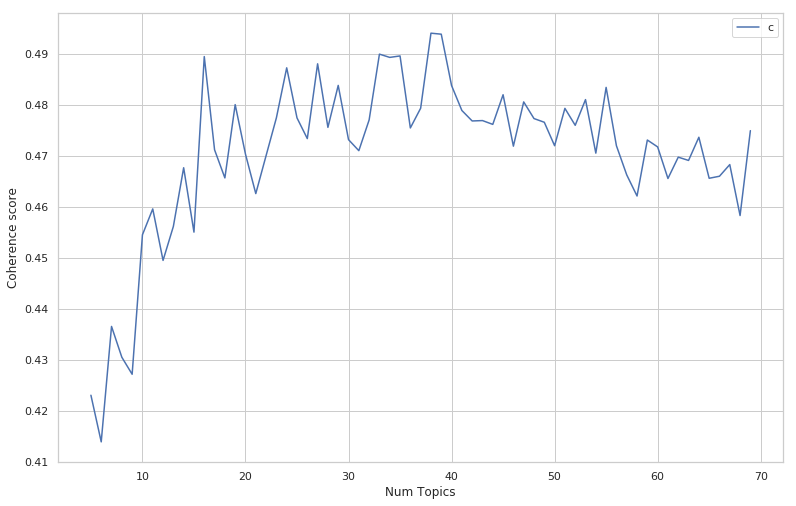

In [256]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start.value, limit=limit.value, step=step.value)

# # Show graph
# limit_=limit.value; start_=start.value; step_=step.value;
x = range(start_, limit_, step_)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# plt.show()
plt.savefig("./figure_su/grid_search.png", dpi=300)

We can see the score line is not quite firm but overall there is a limitation around 0.48. That is the highest bound we could reach. Although it is possible to choos very high topic numbers, it cannot explain itself in fact. Thus, the key is to look around 20-40 base on experts' experience.

To be clear, print the detailed information of our training: 

In [191]:
# Print the coherence scores
i =0
for m, cv in zip(x, coherence_values):
    print("Index = ",i,"Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i = i+1

Index =  0 Num Topics = 5  has Coherence Value of 0.4231
Index =  1 Num Topics = 6  has Coherence Value of 0.4139
Index =  2 Num Topics = 7  has Coherence Value of 0.4366
Index =  3 Num Topics = 8  has Coherence Value of 0.4305
Index =  4 Num Topics = 9  has Coherence Value of 0.4272
Index =  5 Num Topics = 10  has Coherence Value of 0.4545
Index =  6 Num Topics = 11  has Coherence Value of 0.4596
Index =  7 Num Topics = 12  has Coherence Value of 0.4495
Index =  8 Num Topics = 13  has Coherence Value of 0.4561
Index =  9 Num Topics = 14  has Coherence Value of 0.4676
Index =  10 Num Topics = 15  has Coherence Value of 0.455
Index =  11 Num Topics = 16  has Coherence Value of 0.4894
Index =  12 Num Topics = 17  has Coherence Value of 0.4712
Index =  13 Num Topics = 18  has Coherence Value of 0.4657
Index =  14 Num Topics = 19  has Coherence Value of 0.48
Index =  15 Num Topics = 20  has Coherence Value of 0.4703
Index =  16 Num Topics = 21  has Coherence Value of 0.4626
Index =  17 Num

Here we choose 30 as the optimal topic number.

>TAKE CARE: the topic number you choose here will be used for all part below.

In [19]:
#Set parameter
print("topic_num:")
topic_num = widgets.IntText(30)
display(topic_num)


topic_num:


IntText(value=30)

In [221]:
model_list_LDA = []
for i in range(5):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topic_num.value, id2word=id2word)
    c = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    model_list_LDA.append((model, c.get_coherence()))
model, tc = max(model_list_LDA, key=lambda x: x[1])
# Save model.
model.save('model.ldamodel')
# Load model.
model = gensim.models.wrappers.LdaMallet.load('model.ldamodel')


In [222]:

# Select the model and print the topics
optimal_model = model#model_list[int((topic_num.value - start.value)/step.value)]
optimal_topic_num = topic_num.value
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

from collections import Counter
import matplotlib.colors as mcolors

topics = optimal_model.show_topics(num_topics=optimal_topic_num, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
df_topic_word = pd.DataFrame(df.groupby('topic_id').apply(concat))
df_topic_word.columns = ['words']
df_topic_word

,words
topic_id,
0,"[lesson, reflection, scaffold, plan, regulation, scaffolding, reflective, pedagogical, planning, metacognitive]"
1,"[analytic, cluster, code, word, behavior, frequency, network, contribution, average, utterance]"
2,"[knowledge_build, collective, contribution, thread, word, object, advance, deep, productive, grade]"
3,"[session, conversation, episode, dialogue, segment, respond, minute, moment, small_group, position]"
4,"[argumentation, argument, claim, reasoning, criterion, quality, intervention, scientific_reason, evaluation, piece]"
5,"[representation, graph, visual, visualization, gaze, drawing, attention, object, display, concept_map]"
6,"[youth, local, pathway, cultural, agency, site, live, life, city, power]"
7,"[workshop, artifact, digital, art, library, maker, creative, creativity, interview, makerspace]"
8,"[gesture, body, object, embody, movement, physical, embodiment, dynamic, spatial, verbal]"


In [224]:
df_topic_word.to_csv("LDA_topic_word.csv")

### 2.4 Set topic label
Topic model needs to set topic label manually. The labels are also created defautly by take first three words in each topic.

In [225]:
tab_contents = []
for i in range(optimal_topic_num):
    tab_contents.append('topic '+str(i))
children = [widgets.Text(description=name, value = df_topic_word.words[ind][0]+'+'
                         +df_topic_word.words[ind][1]+'+'+df_topic_word.words[ind][2] ) for name, ind in zip(tab_contents, range(len(tab_contents)))]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

In [226]:
labels = []
for ch in tab.children:
    labels.append(ch.value)
df_topic_label = pd.DataFrame(labels)
df_topic_label.columns = ['topic_label']
print("****Run this cell to generate topic label dataframe****")

****Run this cell to generate topic label dataframe****


## 3. Topic Exploration

### 3.1 Finding the dominant topic in each paper
One of the practical application of topic modeling is to determine what topic a given document is about. Based on the vector of a document, we take the first, the one takes largest proportion in doc, as its dominant topic. Also, we add each documents' dominant topic contribution(proportion) and label to dataframe. In the last part, the labels of paper will be used for cluster.

In [227]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=contents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         print(i)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# optimal_model = gensim.models.wrappers.LdaMallet('./mallet/bin/mallet', corpus=corpus, num_topics=20, id2word=id2word)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=contents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic = df_dominant_topic.merge(df_topic_label, left_on='Dominant_Topic', right_index=True).sort_values(by = 'Document_No')
# Show
pd.set_option('display.max_colwidth', 50)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_label
0,0,11.0,0.4554,"text, feedback, read, revision, critique, stor...",Teaching Struggling Middle School Readers\nto ...,text+feedback+read
1,1,23.0,0.1745,"identity, stem, position, woman, scientist, ge...",Becoming a Computer Scientist: Early Results o...,identity+stem+position
2,2,15.0,0.2067,"source, history, literacy, historical, public,...","Science, Technology, Body and Personhood: The ...",source+history+literacy
3,3,5.0,0.3557,"representation, graph, visual, visualization, ...",“With-Me-Ness”: A Gaze-Measure for Students’ A...,representation+graph+visual
4,4,15.0,0.3144,"source, history, literacy, historical, public,...",The Role of Inconsistencies in Collaborative K...,source+history+literacy
5,5,10.0,0.4173,"unit, biology, progression, map, complex_syste...",A Design Inquiry: Bridging Assessment and Curr...,unit+biology+progression
6,6,25.0,0.2338,"implementation, professional_development, inno...",Design Principles for Motivating Learning with...,implementation+professional_development+innova...
7,7,13.0,0.1341,"physical, virtual, exhibit, museum, affordance...",What’s Happening in the “Quantified Self” Move...,physical+virtual+exhibit
8,8,27.0,0.2716,"simulation, physics, interview, energy, phenom...",The Nature of Student Thinking and Its Implica...,simulation+physics+interview
9,9,8.0,0.2847,"gesture, body, object, embody, movement, physi...",Teaching about Confidence Intervals:\nHow Inst...,gesture+body+object


### 3.2 Find the most representative document for each topic
The cell before shows contribution, and in this cell, we sort this value in every topic. In this is the way, it shows what is the most representative document in a topic. And by looking through the doc, we can find a good example of the topic and have a sense of the content.

In [228]:

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.merge(df_topic_label, left_index=True, right_index=True)

# Show
pd.set_option('display.max_colwidth', 50)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,topic_label
0,0.0,0.4681,"lesson, reflection, scaffold, plan, regulation...",Insights Into Teacher Reflective Practice Duri...,lesson+reflection+scaffold
1,1.0,0.6743,"analytic, cluster, code, word, behavior, frequ...",Time and Semantic Similarity – What is the Bes...,analytic+cluster+code
2,2.0,0.7077,"knowledge_build, collective, contribution, thr...",Reflective Structuration of Knowledge Building...,knowledge_build+collective+contribution
3,3.0,0.5057,"session, conversation, episode, dialogue, segm...",Inexplicable Silence:\nAn Uncomfortable Analys...,session+conversation+episode
4,4.0,0.4986,"argumentation, argument, claim, reasoning, cri...",Changes in Students’ Use of Epistemic Criteria...,argumentation+argument+claim
5,5.0,0.5230,"representation, graph, visual, visualization, ...",Visual Augmentation of Deictic Gestures in MOO...,representation+graph+visual
6,6.0,0.5390,"youth, local, pathway, cultural, agency, site,...","Friendship, Participation, and Site Design in ...",youth+local+pathway
7,7.0,0.4993,"workshop, artifact, digital, art, library, mak...",Maker Portfolios as Learning and Community-Bui...,workshop+artifact+digital
8,8.0,0.5567,"gesture, body, object, embody, movement, physi...",Collaborative Gesture as a Case of Distributed...,gesture+body+object
9,9.0,0.5079,"theoretical, culture, cultural, notion, mediat...",Communities of Learning Practice: Balancing Em...,theoretical+culture+cultural


We could also use the dataframe to look for details of topic including specific keyword like "mooc". The text's topic having the full name of mooc confirm the model's accuracy.

In [229]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Keywords.str.contains('mooc')]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,topic_label
29,29.0,0.4793,"instructor, post, mooc, week, communication, a...",Mixing In-Class and Online Learning: Content M...,instructor+post+mooc


### 3.3 Topic distribution across documents
The figure presents an overview of volums distribution among topics. y-axis is the number of documents which have dominant topic on x value. The four largest topics are "implementation+network+innovation", "condition+problem_solve+solution", "youth+agency+history" and "theoretical+dimension+notion". All of them have volumns of 60. On the other hand, "team+museum+exhibit" get the lowest count around 20.  

These Results could be interpreted as the higher volumn a topic has, the more widely it is discussed or the more attention it is paid to. For example, the problem solving is one of the popular directions in Learning Science and has quite lot experts reasearch on it. Thus, researchers' large amount and topic's own widespreadness make this topic appearing frquently in documents. But for small topics like museum exhibition, there could be two possible explainations. One is the topic is not popular and few people is interested in it. The other reason is a new bornd area does not have too much reasearch accumlation and it is hard to be a pioneer.

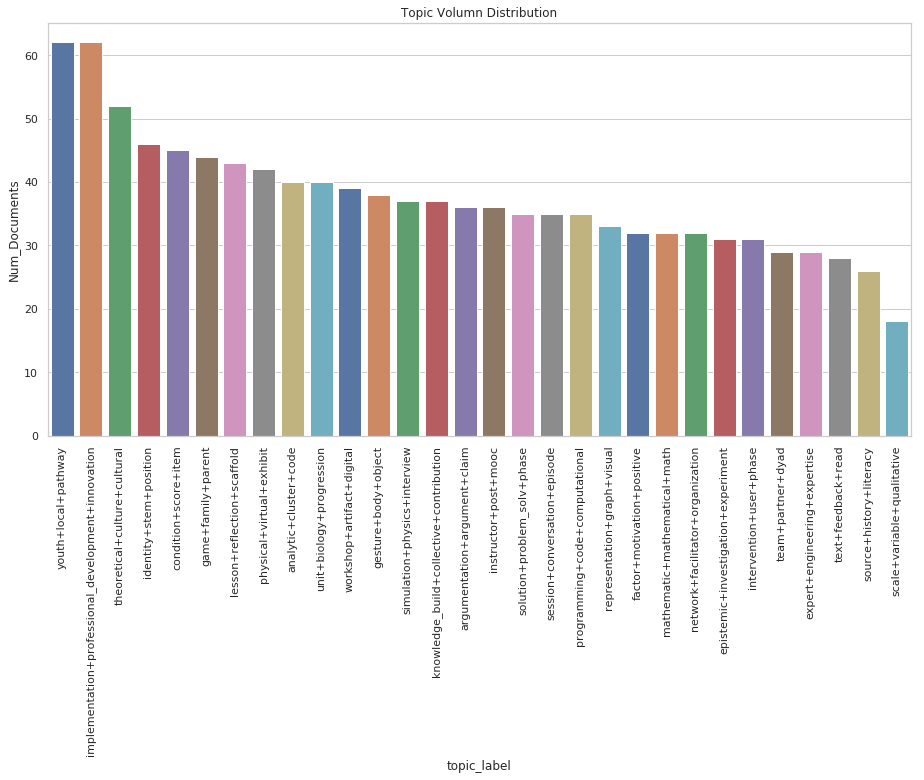

In [265]:
fig,ax = plt.subplots()
fig.set_size_inches(13, 11)
df_dominant_topics = pd.DataFrame(df_topic_sents_keywords['Dominant_Topic'].value_counts()).merge(df_topic_label, left_index=True, right_index=True)
df_dominant_topics.columns = ['Num_Documents', 'topic_label']
g = sns.barplot(x='topic_label',y ='Num_Documents', data=df_dominant_topics, palette="deep")
g.set_xticklabels(df_dominant_topics.topic_label,rotation=90)
g.set_title("Topic Volumn Distribution")
plt.tight_layout()
pic = g.get_figure()

pic.savefig("./figure_su/Topic_Volumn_Distribution.png", dpi=300)

To drill down, we checked topic distribution chage over years. Each year's documents were seen as an whole document so that we input it to trained LDA model and get topic distribution for this year as results. 

We plot Significant Topic Proportion Chage over Years where y-axis `topic_proportion` means the topic percentage in that year. To make figure clear, we only draw topics having topic_propotion standard deviation `threshold_std` larger than 0.015. `threshold_std` reflects change degree of a list of value, which is used here to control flucuation. The higher the threshold is, the more satisfied lines have. 

Figure reveals that, in most case, the lines are in M and W shape, which means every other year's data are not continuous. Consider the fact we have two conference: ICLS holded in even year, CSCL in odd year. This explains data's feature.

>`threshold_std`: float, is the filter of stadard deviation and  can be seen as topic changed obviously level.

In [231]:
# take some mins to run
topic_prop = []
ind = 0
for n in time_slice:
    topic_prop.append(optimal_model[[item for sublist in corpus[ind: ind+n] for item in sublist]])
    ind = ind + n

count_df = pd.DataFrame()
year = first_year
for t in topic_prop:
    df = pd.DataFrame(t)
    df['year'] = year
    if (year%2):
        df['conf'] = 'CSCL'
    else:
        df['conf'] = 'ICLS'
    
    df.columns = ['topic', 'proportion','year','conf']
    if year == first_year or year == first_year+1:
        df['increase'] = 0
    else:
        df['increase'] = df['proportion'] - count_df[count_df.year==year-2].proportion
    df = pd.concat((df, df_topic_label), axis=1)
    count_df = pd.concat((count_df, df), axis=0)
    year = year + 1
count_df.columns = ['topic', 'topic_proportion','year','conf', 'increase', 'topic_label']
count_df =count_df.reset_index()
count_df = count_df.drop('index',axis=1)
count_df['year'] = count_df['year'].astype(str)
# count_df.head()

In [241]:
#Set parameter
print("threshold_std:")
threshold_std = widgets.FloatText(0.015)
display(threshold_std)


threshold_std:


FloatText(value=0.015)

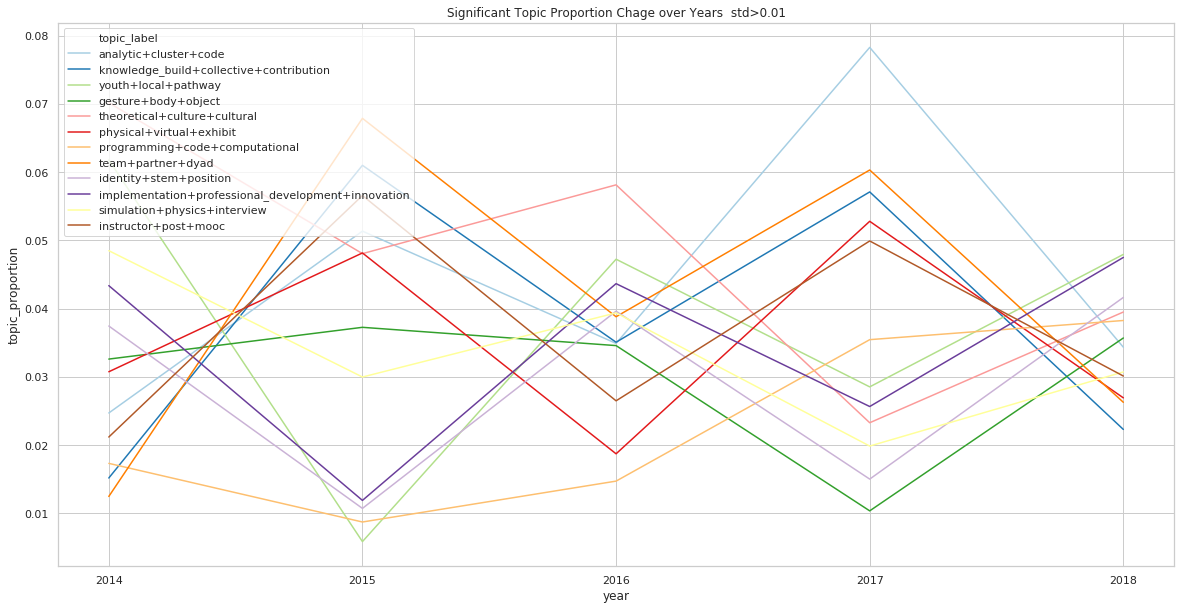

In [244]:
#plot the two conferences topic propotion change having topic propotion std>0.015

fig,ax = plt.subplots()
fig.set_size_inches(20, 10)
data =  count_df[count_df.topic.apply(lambda x :x in count_df.groupby(['topic']).std()[count_df.groupby(['topic']).std().topic_proportion>threshold_std.value].index.values)]
g = sns.lineplot(x='year', y='topic_proportion', hue='topic_label', data=data, 
                 palette=sns.color_palette("Paired", n_colors=len(data.topic_label.unique()))
                ).set_title("Significant Topic Proportion Chage over Years  std>"+str(threshold_std.value))
ax.legend(loc='upper left')
g.get_figure().savefig("./figure_su/Significant_Topic_Proportion_Chage_over_Years.png", dpi=300)


Then we try to eliminate the two conferences' difference.

For topic evolution over time, we use a line chart with topic on the legend. The increment are not firm: topic2 for example, few people is concerned about the identity in ICLS and the proportion does not change much, but in CSCL it is high and keep increasing. As a result, the increment plot (year-the other year) could be positive->zero->position, and if we consider it is the overall situation, it can be explained as people’s attention fluctuate year by year, which cannot do not give a plausible result. 

"culture+history" is alway decreasing
"Mooc" and "robot" are rising

>`threshold_std`: float, is the filter of stadard deviation and  can be seen as topic changed obviously level.

In [245]:
#Set parameter
print("threshold_std:")
threshold_std = widgets.FloatText(0.01)
display(threshold_std)


threshold_std:


FloatText(value=0.01)

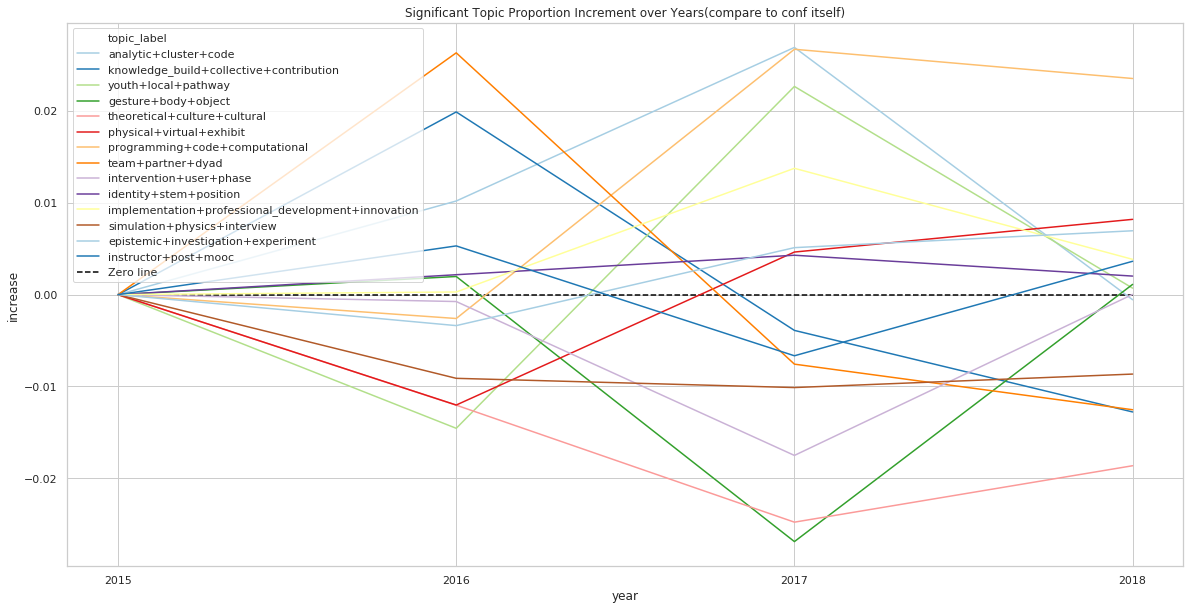

In [248]:
#plot overall relative incresment having topic proportion chage std>0.01
fig,ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.set(style="whitegrid")

ax.hlines(0,0,len(time_slice)-2, color='black', linestyles='dashed', label='Zero line')

data =  count_df[count_df.topic.apply(lambda x :x in count_df.groupby(['topic']).std()[count_df.groupby(['topic']).std().topic_proportion>threshold_std.value].index.values)]
g = sns.lineplot(x='year', y='increase', hue='topic_label',
                 data=data[data.year.astype(int)>first_year], 
                 palette=sns.color_palette("Paired", n_colors=len(data.topic_label.unique()))
                ).set_title("Significant Topic Proportion Increment over Years(compare to conf itself)")
# ax.legend(loc='upper left')
g.get_figure().savefig("./figure_su/Significant_Topic_Proportion_Increment_over_Years.png", dpi=300)


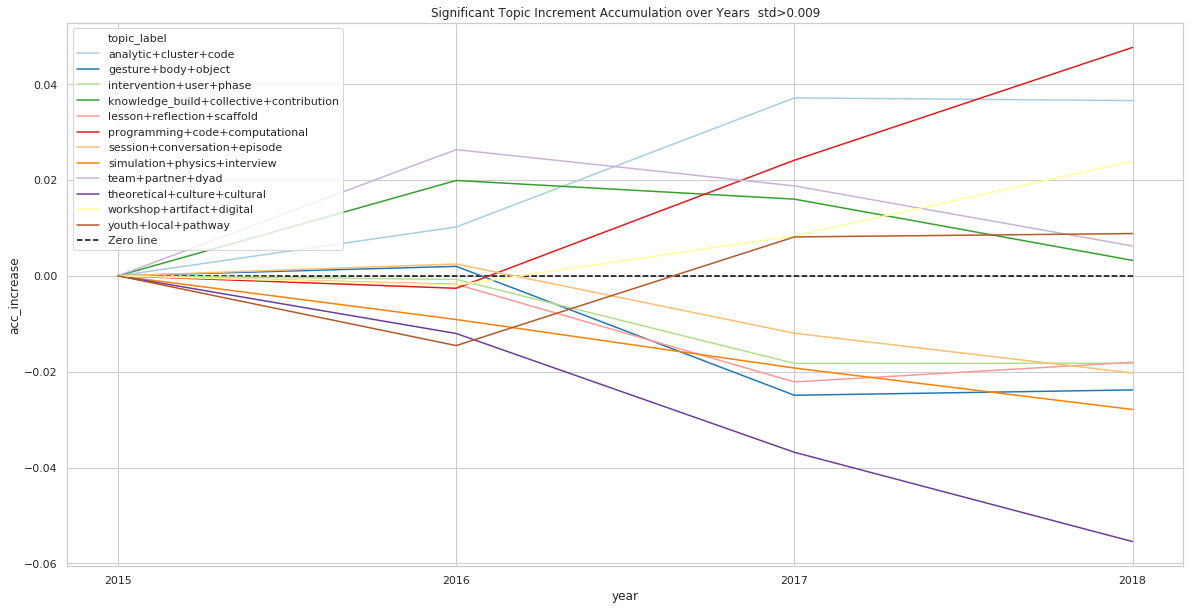

In [250]:
#accumulate sum every year's increment to  show the total proportion change from the original year(2014,2015)
data = count_df[['year', 'increase','topic_label']].groupby(by=['topic_label','year']).sum().groupby(level=[0]).cumsum()
data = data.reset_index()
data.columns = ['topic_label', 'year', 'acc_increase']
fig,ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.hlines(0,0,len(time_slice)-2, color='black', linestyles='dashed', label='Zero line')
data =  data[data.topic_label.apply(lambda x :x in data.groupby(['topic_label']).std()[data.groupby(['topic_label']).std().acc_increase>threshold_std.value].index.values)]
g = sns.lineplot(x='year', y='acc_increase', hue='topic_label', data=data[data.year!=str(first_year)], 
                 palette=sns.color_palette("Paired", n_colors=len(data.topic_label.unique()))
                ).set_title("Significant Topic Increment Accumulation over Years  std>"+str(threshold_std.value))
ax.legend(loc='upper left')
g.get_figure().savefig("./figure_su/Significant_Topic_Increment_Accumulation_over_Years.png", dpi=300)
# data

Also, we can plot the topic change inside a conference separately. The result is firm and explainable. For example, the topic "theoretical+ authentic+dimension" keep decresing for long time. This may clue that researchers pay less attention on this direction. On the contrary, "analytic+mooc" has a sharp increment from 2014-2016, which also comfirm the MOOC hot trend that time. On the other hand, robot related topic become suddenly popular afer 2016.  

Mooc is nor significant beacuse it is in ICLS which is not so concerned about it, but in CSCL in firgure 1 the mooc proportion is high and rising quickly!

>`threshold_std`: float, is the filter of stadard deviation and  can be seen as topic changed obviously level.

>`conf_name`: text, is the interested conference, should be CSCL or ICLS

In [237]:
#Set parameter
print("threshold_std:")
threshold_std = widgets.FloatText(0.015)
display(threshold_std)
print("conf_name:")
conf_name = widgets.Text(value='ICLS')
display(conf_name)

threshold_std:


FloatText(value=0.015)

conf_name:


Text(value='ICLS')

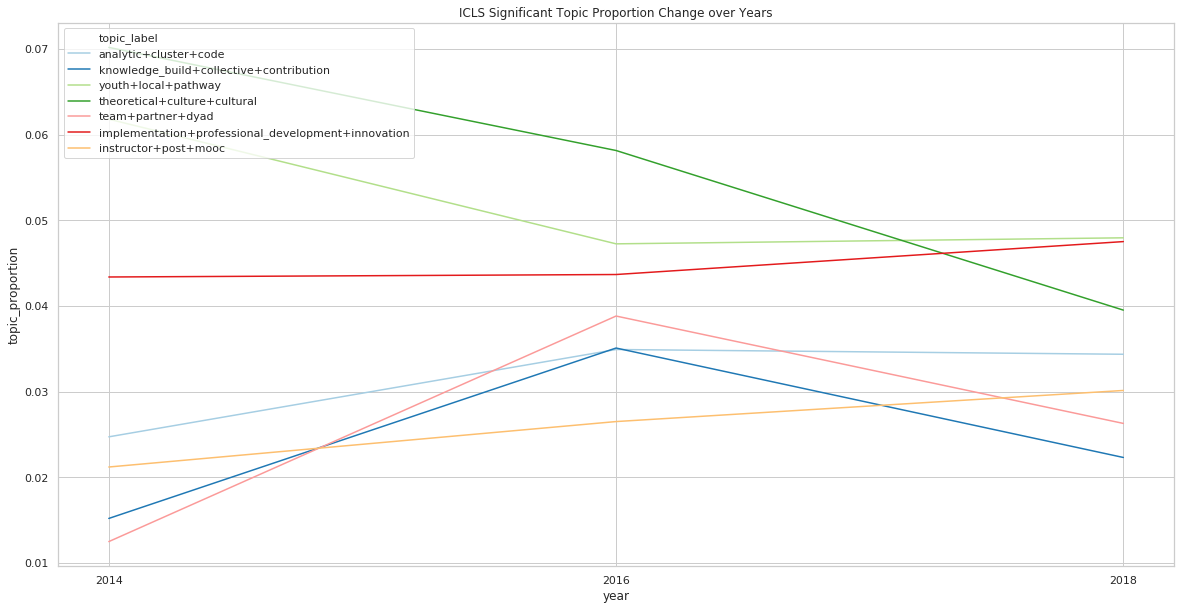

In [238]:
#plot the ICLS conference topic propotion change having std>0.015

fig,ax = plt.subplots()
fig.set_size_inches(20, 10)
data =  count_df[count_df.conf == conf_name.value][count_df[count_df.conf == conf_name.value].topic.apply(lambda x :x in count_df.groupby(['topic']).std()[count_df.groupby(['topic']).std().topic_proportion>threshold_std.value].index.values)]
g = sns.lineplot(x='year', y='topic_proportion', hue='topic_label',data=data, 
             palette=sns.color_palette("Paired", n_colors=len(data.topic_label.unique()))
            ).set_title("ICLS Significant Topic Proportion Change over Years")
# figure size in inches
ax.legend(loc='upper left')
plt.show()

This plot compares "ICLS" and "CSCL" topic attention over all years. We can see each conference has its own special preference. CSCL, Computer-Supported Collaborative Learning, is more about technical related topics like "analytic+mooc+network", "pair+code+dyad" because this conference pay more attention on learning and computer. While ICLS is about general learning science, or the whole circle and maybe topic coverage is what matters. Thus, the percentage std is much smaller than that of CSCL.

Based on it, we could also refer conference's taste and predict a paper could be accepted or not. First use the model to analyze topic of this paper and compare the proportion of the topic in conferences. So, we can see which one is more possible to accept it!



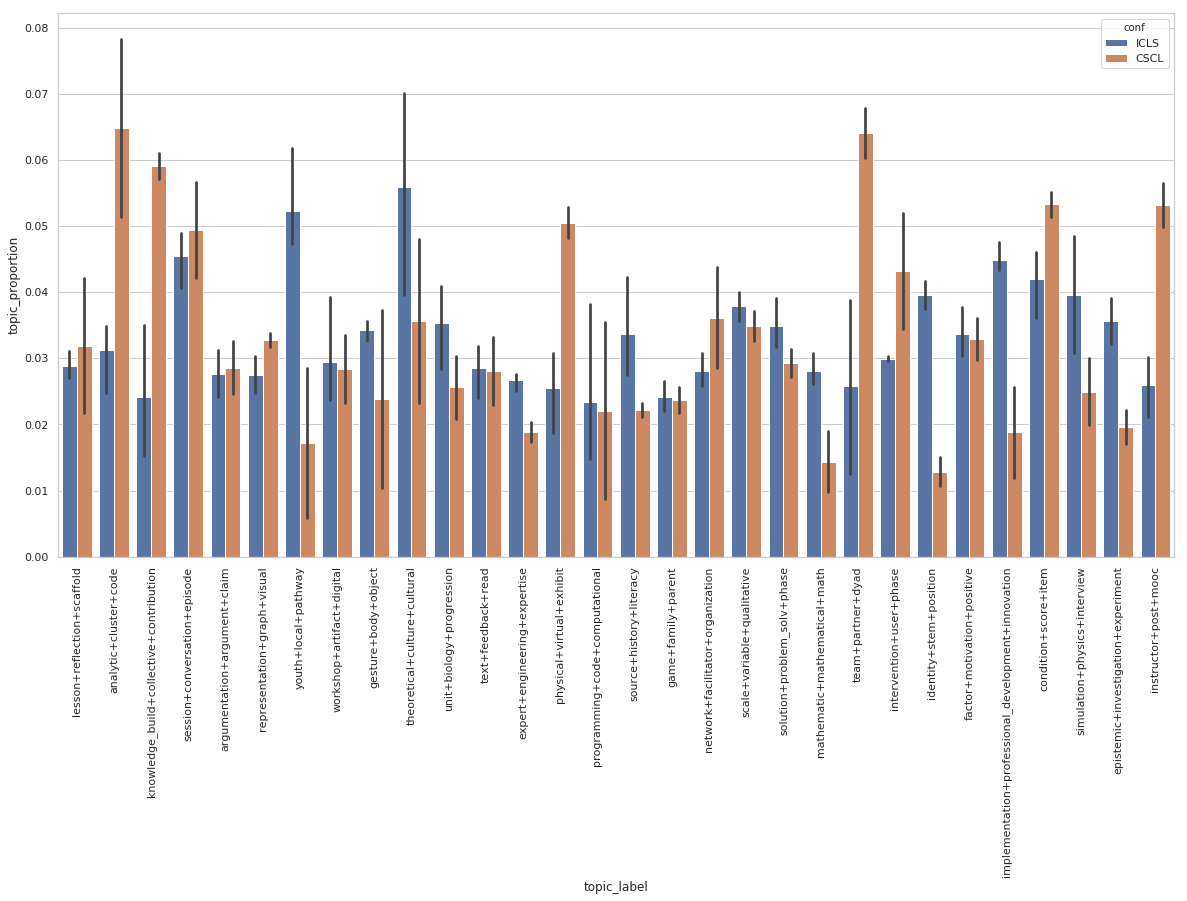

In [239]:
#topic proportion comparison between two conf overall

fig,ax = plt.subplots()
fig.set_size_inches(20, 10)

g =sns.catplot(x="topic_label", y="topic_proportion",hue='conf',
                data=count_df, kind="bar",
                height=4, aspect=.5,ax = ax
              )

# g.set_xticklabels(df_topic_label.topic_label,rotation=90)
plt.close(2)
plt.xticks(rotation=90)
plt.show()
g.get_figure().save_fig

## Dynamic topic modeling

Dynamic Topic Models (DTMs), as presented by Blei and Lafferty, address this problem by extending the idea of LDA to allow topic representations to evolve over fixed time intervals such as years. Specifically, the documents within each time slice are modeled with a topic model of the same dimension, and each topic in time slice t evolves from a corresponding topic in time slice t-1.

The generative process of LDA remains more or less the same aside from the key difference that the overall topic distribution and the term distribution for each topic differ depending on the time slice. In particular, the parameters for these distributions “evolve” at each time slice by being drawn from distributions centered around the corresponding values from the previous time slice. The end result of this is a series of LDA-like topic models that are sequentially tied together. A topic learned by a DTM is thus a sequence of related distributions over terms. With this intuition, I move now to its application.

Run the cell blow to generage Dynamic topic model. The topic number is same as the optimal topic number as we choose before.

In [35]:
# Build LDA seq model

from gensim.models import ldaseqmodel
from gensim.test.utils import datapath
%time ldaseq_model = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slice, num_topics=optimal_topic_num)
temp_file = datapath("ldaseq_model")
ldaseq_model.save(temp_file)

# Load a potentially pre-trained model from disk.
ldaseq_model = ldaseqmodel.LdaSeqModel.load(temp_file)


CPU times: user 10h 48min 26s, sys: 38.8 s, total: 10h 49min 5s
Wall time: 10h 45min 35s


Next cell shows one year's word distribution in topics. The topic number is the same with the one we set in part 1.

In [36]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df_topic_word_dynamic = pd.DataFrame()
for n in range(optimal_topic_num):
    k = pd.DataFrame(ldaseq_model.print_topic_times(topic=n, top_terms=10)[-1])
    k.columns = ['word', 'value']
    k['topic_id'] = n
    df_topic_word_dynamic = pd.concat([df_topic_word_dynamic, k])
df_topic_word_dynamic = pd.DataFrame(df_topic_word_dynamic.groupby('topic_id').apply(concat))
df_topic_word_dynamic.columns = ['words']
df_topic_word_dynamic

,words
topic_id,
0,"[regulation, behavior, metacognitive, network, problem_solv, regulate, self, code, metacognition, self_regulat]"
1,"[mathematic, survey, math, score, achievement, item, factor, grade, self_efficacy, motivation]"
2,"[epistemic, argumentation, claim, argument, criterion, scientist, source, reflection, reasoning, quality]"
3,"[youth, stem, mentor, medium, maker, library, makerspace, art, home, site]"
4,"[gesture, mathematical, object, mathematic, body, embody, reasoning, movement, dynamic, physical]"
5,"[family, parent, facilitator, workshop, interview, adult, day, facilitation, informal, search]"
6,"[mooc, analytic, cluster, network, partner, word, contribution, post, qualitative, distance]"
7,"[session, episode, conversation, small_group, whole_class, scaffold, norm, position, contribution, minute]"
8,"[museum, exhibit, visitor, leadership, climate_change, simulation, informal, silence, molecule, conversation]"


Same as before, we should label each topic based on context which is used later.

In [223]:
tab_contents = []
for i in range(optimal_topic_num):
    tab_contents.append('topic '+str(i))
children = [widgets.Text(description=name, value = df_topic_word_dynamic.words[ind][0]+'+'
                         +df_topic_word_dynamic.words[ind][1]+'+'+df_topic_word_dynamic.words[ind][2] ) for name, ind in zip(tab_contents, range(len(tab_contents)))]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

In [38]:
labels = []
for ch in tab.children:
    labels.append(ch.value)
df_topic_label_dynamic = pd.DataFrame(labels)
df_topic_label_dynamic.columns = ['topic_label']
print("****Run this cell to generate topic label dataframe****")
# df_topic_label_dynamic

****Run this cell to generate topic label dataframe****


This is an interactive widght to visulize word percentage in a single topic. In order to find out new word present and significant chage over years. We use `threshold_std` is the threshold of standard deviation. The higher the threshold is, the more change degree can be shown.

>`topic`: text, is the label of a topic

>`threshold_std`: float, is the filter of stadard deviation and  can be seen as topic changed obviously level.

In [39]:
def print_topic_change(topic=0, threshold_std=0.015):
    df_time = pd.DataFrame()
    t=ldaseq_model.print_topic_times(topic=topic,top_terms=30)
    for i in range(len(t)):
        temp = pd.DataFrame(t[i], columns=['word', 'value'])
        temp['year'] = first_year + i 
        df_time = pd.concat([df_time, temp])
    df_time['year'] = df_time['year'].astype(str)
    t = df_time[['word','value']].groupby(['word']).std()
    t.columns = ['std']
    df_time = df_time.merge(t, left_on='word', right_index=True)
    data =df_time[df_time['std']>threshold_std]
    # Line plot
    sns.set(rc={'figure.figsize':(13, 8.27)})
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='year', y='value',
                      hue="word", markers=True, dashes=False, data=data,
                     palette=sns.color_palette("Paired", n_colors=len(data.word.unique()))
                     )
    plt.legend(loc='upper left')
    plt.show()

In [40]:
df_topic_label_dynamic.iloc[0][0]

'regulation+behavior+metacognitive'

In [106]:
#Set parameter
print("topic:")
topic = widgets.Text(value = df_topic_label_dynamic.iloc[0][0])
display(topic)
print("threshold_std:")
threshold_std = widgets.FloatText(0.0004)
display(threshold_std)

topic:


Text(value='regulation+behavior+metacognitive')

threshold_std:


FloatText(value=0.0004)

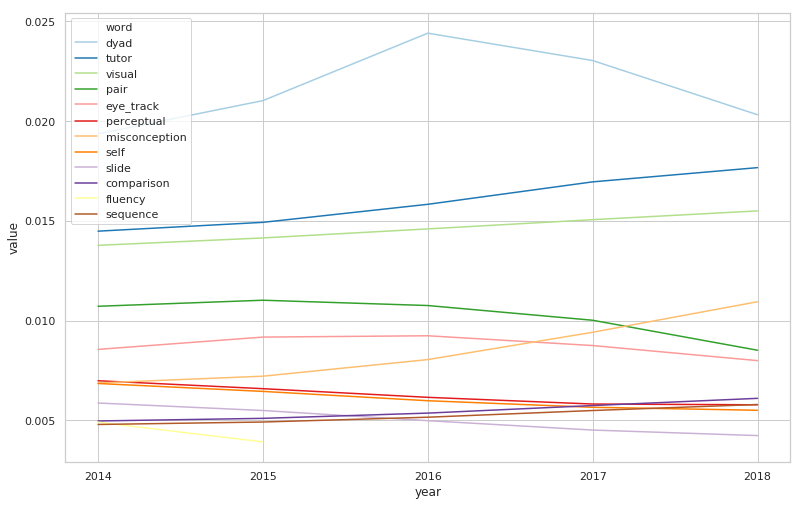

In [109]:
print_topic_change(topic=df_topic_label_dynamic[df_topic_label_dynamic.topic_label == topic.value].index[0], threshold_std=threshold_std.value)

It is no surprise then that human rights is a perennial topic at the General Debate and one that the model was able to discover. Despite the notion of gender equality appearing in the charter quoted above, the model shows that it still took quite some time for the terms “woman” and “gender” to really catch on. Also, note the rising use of “humankind” coupled with the decline of the use of “mankind”.

## The author-topic model
The author-topic model is an extension of Latent Dirichlet Allocation (LDA), that allows us to learn topic representations of authors in a corpus. The model can be applied to any kinds of labels on documents, such as tags on posts on the web. The model can be used as a novel way of data exploration, as features in machine learning pipelines, for author (or tag) prediction, or to simply leverage your topic model with existing metadata.


In [43]:
#get information about author and document id
docid_pd = pd.DataFrame.from_dict(docid, orient='index')
docid_pd.columns = ['file']
docid_pd['id'] = docid_pd.index

author_data = pd.read_csv('author_data.csv')
author_data = author_data.merge(docid_pd, on='file').drop_duplicates()

#Create author2doc
author2doc = dict()
t = author_data[['long_name', 'id']].drop_duplicates()
for index, row in t.iterrows():
    author_name = row.long_name
    if not author2doc.get(author_name):
        # This is a new author.
        author2doc[author_name] = []
        i += 1

    # Add document IDs to author.
    author2doc[author_name].extend([row.id])
# author2doc

#Train
from gensim.models import AuthorTopicModel
model_list_ATM = []
for i in range(5):
    model = AuthorTopicModel(corpus=corpus, num_topics=optimal_topic_num, id2word=id2word, \
                    author2doc=author2doc, chunksize=2000, passes=100, gamma_threshold=1e-10, \
                    eval_every=0, iterations=1, random_state=i)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list_ATM.append((model, tc))
    
model, tc = max(model_list_ATM, key=lambda x: x[1])
# Save model.
model.save('model.atmodel')
# Load model.
model = AuthorTopicModel.load('model.atmodel')

print("****Run this cell to generate ATM****")
print('Number of authors: %d' % len(author2doc))
print('Number of documents: %d' % len(corpus))
print('Topic coherence: %.3e' %tc)

****Run this cell to generate ATM****
Number of authors: 2357
Number of documents: 1125
Topic coherence: -3.955e+01


In [44]:
df_topic_word_author = pd.DataFrame()
for n in range(optimal_topic_num):
    k = pd.DataFrame(model.show_topic(n))
    k.columns = ['word', 'value']
    k['topic_id'] = n
    df_topic_word_author = pd.concat([df_topic_word_author, k])
df_topic_word_author = pd.DataFrame(df_topic_word_author.groupby('topic_id').apply(concat))
df_topic_word_author.columns = ['words']
df_topic_word_author

,words
topic_id,
0,"[argumentation, quality, argument, partner, control, team, attitude, awareness, communication, conflict]"
1,"[artifact, studio, session, object, representation, prototype, multimodal, mode, sketch, story]"
2,"[engineering, network, expert, engineer, epistemic, code, scientific_reason, domain, novice, solution]"
3,"[parent, woman, situate, workshop, organization, participatory, position, identity, meeting, gender]"
4,"[dyad, pair, gaze, tutor, code, behavior, condition, session, eye_track, average]"
5,"[representation, transfer, condition, comparison, receive, visual, misconception, sequence, chemistry, enhance]"
6,"[event, theoretical, complexity, stage, notion, professional_development, segment, agency, mediate, construction]"
7,"[body, embody, embodiment, particle, physical, rule, movement, motion, object, step]"
8,"[facilitator, authentic, identity, culture, personal, ownership, self, authenticity, want, day]"


In [45]:
tab_contents = []
for i in range(optimal_topic_num):
    tab_contents.append('topic '+str(i))
children = [widgets.Text(description=name, value = df_topic_word_author.words[ind][0]+'+'
                         +df_topic_word_author.words[ind][1]+'+'+df_topic_word_author.words[ind][2] ) for name, ind in zip(tab_contents, range(len(tab_contents)))]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

In [46]:
labels = []
for ch in tab.children:
    labels.append(ch.value)
df_topic_word_author = pd.DataFrame(labels)
df_topic_word_author.columns = ['topic_label']
print("****Run this cell to generate topic label dataframe****")
topic_labels = df_topic_word_author.topic_label.tolist()
# df_topic_word_author

****Run this cell to generate topic label dataframe****


### Explore author-topic representation
Now that we have trained a model, we can start exploring the authors and the topics.

First, let's simply print the most important words in the topics. Below we have printed topic 0. As we can see, each topic is associated with a set of words, and each word has a probability of being expressed under that topic.

In [47]:
#Set parameter
print("author_name:")
author_name = widgets.Text(value ='Dillenbourg, Pierre')
display(author_name)

author_name:


Text(value='Dillenbourg, Pierre')

In [48]:
from pprint import pprint
def show_author(name):
    print('\n%s' % name)
    print('Docs:', model.author2doc[name])
    print('Topics:')
    pprint([(topic_labels[topic[0]], topic[1]) for topic in model[name]])
show_author(author_name.value)


Dillenbourg, Pierre
Docs: [476, 475, 489, 341, 582, 334, 529, 1119, 350]
Topics:
[('dyad+pair+gaze', 0.9993636061689724)]


In [49]:
#Set parameter
print("topic_name:")
topic_name = widgets.Text(value =df_topic_word_author.iloc[model[author_name.value][0][0]][0])
display(topic_name)

topic_name:


Text(value='dyad+pair+gaze')

In [50]:
model.show_topic(df_topic_word_author[df_topic_word_author.topic_label == topic_name.value].index[0])

[('dyad', 0.017076747869757058),
 ('pair', 0.01639554820395112),
 ('gaze', 0.01384381015038279),
 ('tutor', 0.01358645271808181),
 ('code', 0.010278566776207056),
 ('behavior', 0.009858906565854612),
 ('condition', 0.009631886178910075),
 ('session', 0.007494974153248318),
 ('eye_track', 0.006987015510640208),
 ('average', 0.0067571506808303166)]

### Plotting the authors
Now we're going to produce the kind of pacific archipelago looking plot below. The goal of this plot is to give you a way to explore the author-topic representation in an intuitive manner.

We take all the author-topic distributions (stored in model.state.gamma) and embed them in a 2D space. To do this, we reduce the dimensionality of this data using t-SNE. t-SNE is a method that attempts to reduce the dimensionality of a dataset, while maintaining the distances between the points. That means that if two authors are close together in the plot below, then their topic distributions are similar.

In the cell below, we transform the author-topic representation into the t-SNE space. We can increase the smallest_author value if we do not want to view all the authors with few documents.

In [51]:
# %%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 2  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

In [52]:
# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

Loading BokehJS ...

The circles in the plot above are individual authors, and their sizes represent the number of documents attributed to the corresponding author. Large clusters of authors tend to reflect some overlap in interest.

At about  (−15,−10)  we have a cluster of ??? like Christof Koch and James M. Bower.

As discussed earlier, the "object recognition" topic was assigned to Sejnowski. If we get the topics of the other authors in Sejnoski's neighborhood, like Peter Dayan, we also get this same topic. Furthermore, we see that this cluster is close to the "neuroscience" cluster discussed above, which is further indication that this topic is about visual perception in the brain.

Other clusters include a reinforcement learning cluster at about  (−5,8) , and a Bayesian modelling cluster at about  (8,−12) .



### Who has the same taste with me?

Each year, most of authors have less than 1 paper per year and it is coresponded to real situation. If we use this one or two papers to indicate a author's preference, the preference problem is reduced to document feature. For example, assume we want to compare two authors with few papers, it is likely to get large bias and is more directly to compare similarity between documents which already implemented in the first part of notebook. Thus, we need to consider author's papers all the time to make firm and steady preference. 

However, this framework uses the cosine distance, but we want to use the Hellinger distance. The Hellinger distance is a natural way of measuring the distance (i.e. dis-similarity) between two probability distributions. Its discrete version is defined as
$$
H(p, q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^K (\sqrt{p_i} - \sqrt{q_i})^2},
$$

where $p$ and $q$ are both topic distributions for two different authors. We define the similarity as
$$
S(p, q) = \frac{1}{1 + H(p, q)}.
$$

In the cell below, we prepare everything we need to perform similarity queries based on the Hellinger distance.

In [53]:
# Make a function that returns similarities based on the Hellinger distance.

from gensim import matutils

# Make a list of all the author-topic distributions.
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

def similarity(vec1, vec2):
    '''Get similarity between two vectors'''
    dist = matutils.hellinger(matutils.sparse2full(vec1, model.num_topics), \
                              matutils.sparse2full(vec2, model.num_topics))
    sim = 1.0 / (1.0 + dist)
    return sim

def get_sims(vec):
    '''Get similarity of vector to all authors.'''
    sims = [similarity(vec, vec2) for vec2 in author_vecs]
    return sims

def get_table(name, top_n=10, smallest_author=2):
    '''
    Get table with similarities, author names, and author sizes.
    Return `top_n` authors as a dataframe.
    
    '''
    
    # Get similarities.
    sims = get_sims(model.get_author_topics(name))

    # Arrange author names, similarities, and author sizes in a list of tuples.
    table = []
    for elem in enumerate(sims):
        author_name = model.id2author[elem[0]]
        sim = elem[1]
        author_size = len(model.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))
            
    # Make dataframe and retrieve top authors.
    df = pd.DataFrame(table, columns=['Author', 'Score', 'Size'])
    df = df.sort_values('Score', ascending=False)[:top_n]
    topic = []
    for name in df.Author:
        topic.append(sorted(model[name], key=lambda x: (x[1]), reverse=True) )
    df['topic'] = topic
    return df

#collect author co authorship and make adjacent matix
def find_coauth(au):
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
            au1 = au.long_name.values[i]
            au2 = au.long_name.values[j]
            co_auth.at[au1,au2] += 1
            co_auth.at[au2,au1] += 1
co_auth = pd.DataFrame(np.zeros(shape=(len(author2doc),len(author2doc))))
co_auth.columns=author_data.long_name.unique()
co_auth.index=author_data.long_name.unique()
t = author_data.groupby(['title']).apply(find_coauth)


In [54]:
#Set parameter
print("author_name:")
author_name = widgets.Text(value ='Dillenbourg, Pierre')
display(author_name)

author_name:


Text(value='Dillenbourg, Pierre')

In [55]:
pd.set_option('display.max_colwidth', 50)
get_table(author_name.value)

,Author,Score,Size,topic
143,"Dillenbourg, Pierre",1.000000,9,"[(4, 0.9993636061689724)]"
560,"Sharma, Kshitij",0.999913,10,"[(4, 0.9996104780265272)]"
198,"Gergle, Darren",0.999160,2,"[(4, 0.9969883788507736)]"
708,"Zufferey, Guillaume",0.933250,2,"[(4, 0.9852140718240426), (16, 0.0101809956044..."
159,"D’Angelo, Sarah",0.912649,2,"[(4, 0.9788783717657814), (19, 0.0182154728268..."
281,"Jermann, Patrick",0.885399,2,"[(4, 0.9633309149687015), (21, 0.0331756958987..."
74,"Cassell, Justine",0.872822,2,"[(4, 0.941862734735302), (12, 0.02177261392715..."
445,"Ogan, Amy",0.858362,5,"[(4, 0.9455807840650335), (12, 0.0537121682209..."
383,"Madaio, Michael",0.821801,2,"[(4, 0.8991739903022868), (12, 0.0665983477315..."
540,"Schneider, Bertrand",0.807722,8,"[(4, 0.8894433095455697), (24, 0.1101348467080..."


### Which paper is the work of Interdiscipline?

Assume every two authors working in a same document are a pair of coauthor. And if the similarity between a pair of coauthor is low enough, we say these two authors are not similar. Or othewise, the similarity above a threshold, they have similar work pattern. 

In order to find the thresholds, first we draw the coauthorship similarity distribution. Accodording to our formula to calculate similarity, the value should between 0.5 and 1. If two authors' preference are not related, the value becomes near 0.5. The distribution is right skewed and the first bin has a really high value. This is same as real situation that it is likely to work with different guys even you do not know. 

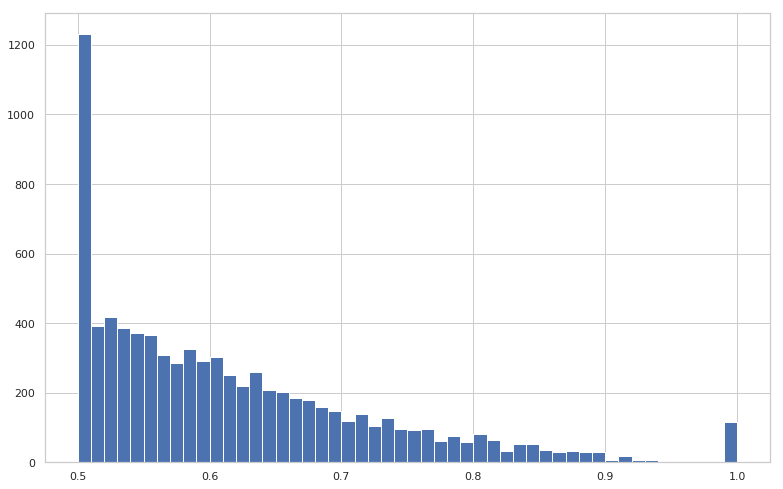

In [75]:

G=nx.Graph()
#add weighted edge

for author in list(author2doc.keys()):
    sims = get_sims(model.get_author_topics(author))
    for elem in enumerate(sims):
        author_ = model.id2author[elem[0]]
        sim = elem[1]
        if (co_auth.loc[author, author_]>0):
            if not G.has_edge(author, author_):
                G.add_edge(author, author_,weight=sim)
            
#diff edges with heavy weight and light weight 
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.7]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.51]

#node position
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=5)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b',style='dashed')
 
    
#get the largest compoents and draw it with different threshold
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
weights_sta = []
for (u,v,d) in largest_cc.edges(data=True):
    weights_sta.append(d['weight'])
    plt.title('weight similarity of coauthors')
plt1 = plt.hist(weights_sta, bins=50)

From the distribution, we can see there are a large amount of author similarity below 0.51. And the truth is one author is likely to be distinct with others. Therefore, we say if an author pair's similarity>0.7, these two authors are `similar`. Whereas the weight<0.51, they are `distinct` and their preference are far from each other.

In [57]:
# #draw network 
# elarge=[(u,v) for (u,v,d) in largest_cc.edges(data=True) if d['weight'] >0.7]
# esmall=[(u,v) for (u,v,d) in largest_cc.edges(data=True) if d['weight'] <=0.51]

# #node position
# pos=nx.spring_layout(largest_cc) # positions for all nodes

# # nodes
# nx.draw_networkx_nodes(largest_cc,pos,node_size=5)

# # edges
# nx.draw_networkx_edges(largest_cc,pos,edgelist=elarge,
#                     width=1)
# nx.draw_networkx_edges(largest_cc,pos,edgelist=esmall,
#                     width=1,alpha=0.5,edge_color='b',style='dashed')
 

In order to find the document with most diversity, we are going to count coauthorship having similariy lower than 0.51 in one document. If the count is large, we could say this paper is a result of cross The more div_num a document has, the more diverse it is. This cannot be seen as the minimum sim because there are more than 800 pairs near lowerbound and their difference are subtle.

Here collect all data we need: In one document, `totoal_num` is number of all possible author cooperation, `div_num` is diverse coauthorship times, and `div_ratio` is `div_num`/`totoal_num`. We sorted the dataframe by ratio. 

In [58]:
#collect author co authorship and make adjacent matix
def cal_MinSim(au):
    min_nu = 0
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
            au1 = au.long_name.values[i]
            au2 = au.long_name.values[j]
            if sim_all.at[au1,au2] <=0.51:
                min_nu += 1
    return min_nu

#calculate similarity between all authors
sim_all = pd.DataFrame(np.zeros(shape=(len(author2doc),len(author2doc))))
sim_all.columns=author_data.long_name.unique()
sim_all.index=author_data.long_name.unique()

for author in list(author2doc.keys()):
    sims = get_sims(model.get_author_topics(author))
    for elem in enumerate(sims):
        author_ = model.id2author[elem[0]]
        sim = elem[1]
        sim_all.at[author, author_] = sim
        sim_all.at[author_, author] = sim
        
pd.options.display.max_rows


df_MinSim_num = pd.DataFrame(author_data.groupby(['title']).apply(cal_MinSim))
df_MinSim_num.columns = ['div_num']
df_MinSim_num = df_MinSim_num.sort_values(by = 'div_num', ascending=False)
df_MinSim_num = df_MinSim_num.merge(pd.DataFrame(author_data.groupby('title').long_name.apply(list)).merge(pd.DataFrame(author_data.groupby('title').agg('count').id), left_index=True, right_index=True)
                    , left_index=True, right_index=True)
df_MinSim_num.columns = ['div_num','name_list', 'auth_count']
df_MinSim_num['totoal_num'] = df_MinSim_num.auth_count * (df_MinSim_num.auth_count-1) / 2
df_MinSim_num['div_ratio'] = df_MinSim_num['div_num']/df_MinSim_num['totoal_num']
df_MinSim_num = df_MinSim_num.sort_values(by = 'div_ratio', ascending=False)
pd.set_option('display.max_colwidth', 100)
df_MinSim_num.head(20)

,div_num,name_list,auth_count,totoal_num,div_ratio
title,,,,,
"The Impact of Principle-Based Reasoning on Hands-on, Project-Based Learning",1,"[Worsley, Marcelo, Blikstein, Paulo]",2,1.0,1.000000
What Do Learning Scientists Do? A Survey of the ISLS Membership,1,"[Yoon, Susan, Hmelo-Silver, Cindy E.]",2,1.0,1.000000
Realizing Research-Practice Connections: Three Cases From the Learning Sciences,3,"[McKenney, Susan, van Aalst, Jan, Forbes, Cory T.]",3,3.0,1.000000
Student Learning of Computational Thinking in A Robotics Curriculum: Transferrable Skills and Relevant Factors,1,"[Chen, Guanhua, Shen, Ji]",2,1.0,1.000000
Using Deficient Models as Scaffolds for Learning Engineering Concepts of Tradeoffs and Optimization,1,"[Dasgupta, Chandan, Moher, Tom]",2,1.0,1.000000
Facilitating Design Research by Mapping Design Research Trajectories,1,"[Ma, Guanzhong, van Aalst, Jan]",2,1.0,1.000000
Influence of Perceptions of Past Collaborative Experiences on Quality of Pre-service Collaboration and Outcomes,1,"[brown, denise, Jordan, Michelle E.]",2,1.0,1.000000
Uncovering the Rich Club Phenomenon in an Online Class,1,"[Huang, Tianhui, Chen, Bodong]",2,1.0,1.000000
Assessment and Collaborative Inquiry: A Review of Assessment-Based Interventions in Technology-Enhanced K-14 Education,1,"[Yang, Yuqin, van Aalst, Jan]",2,1.0,1.000000


Then we filter on the author count because if it is too small, the ratio is easy to be large.

In [59]:
df_MinSim_num[df_MinSim_num['auth_count']>3].head(20)

,div_num,name_list,auth_count,totoal_num,div_ratio
title,,,,,
Between the Lines: The Role of Curriculum Materials and Teacher Language in Communicating Ideas about Scientific Modeling,13,"[Sherwood, Carrie-Anne, Allen, Carrie D., Moorthy, Savitha, D'Angelo, Cynthia, Stanford, Tina, H...",6,15.0,0.866667
Professional Development of Science Teachers in Underserved Communities: an Initial Report from the Field,5,"[Fuhrmann, Tamar, Fernandez, Cassia, Hochgreb-Haegele, Tatiana, Blikstein, Paulo]",4,6.0,0.833333
Examining the Role of Unpacking 3-Dimensional Teaching and Learning in Museum-Based Professional Development,12,"[Vaishampayan, Gauri A., Price, Aaron, Kauffman, Kyle, Messersmith, Patricia, Rico-Beck, Laura, ...",6,15.0,0.800000
Secondary Students’ Evaluation of Inappropriate Strategies of Reasoning about Evidence under a Scientific Explanation,4,"[Ma, Guanzhong, van Aalst, Jan, Chan, Carol, Wang, Jing]",4,6.0,0.666667
How to Enjoy Writing Papers: Supporting Literature-Based Inquiry Learning to Reduce Procrastination and Foster Ownership and Positive Emotions,4,"[Eberle, Julia, Schönfeld, Tim, Arukovic, Selma, Rummel, Nikol]",4,6.0,0.666667
Using Machine Learning Techniques to Capture Engineering Design Behaviors,22,"[Bywater, Jim P, Floryan, Mark, Chiu, Jennifer L., Chao, Jie, Schimpf, Corey, Xie, Charles, Viei...",9,36.0,0.611111
Beyond Just Getting Our Word Out: Creating Pipelines From Learning Sciences Research to Educational Practices,9,"[Jacobson, Michael J., Lund, Kristine, Hovey, Christopher M, Vatrapu, Ravi, Kolodner, Janet L., ...",6,15.0,0.600000
A Qualitative Exploration of Self- and Socially Shared Regulation in Online Collaborative Learning,6,"[Hensley, Lauren, Cutshall, Jessica, Law, Victor, Xie, Kui, Lu, Lin]",5,10.0,0.600000
Data Moves: Restructuring Data for Inquiry in a Simulation and Data Analysis Environment,20,"[Wilkerson, Michelle, Lanouette, Kathryn, Shareff, Rebecca, St. Clair M St. Clair St. Clair, Nat...",9,36.0,0.555556


### Which topic is the place  that diversity possibly happen?

What about coauthorship diversity in a topic? We also try to combine document with topic through optimum mallet topic model we generate before. The mallet model give documents their dominant topic, and we consider the topic is the docments' classification label. Then calculate the diverse number mean to see which topic is the special.

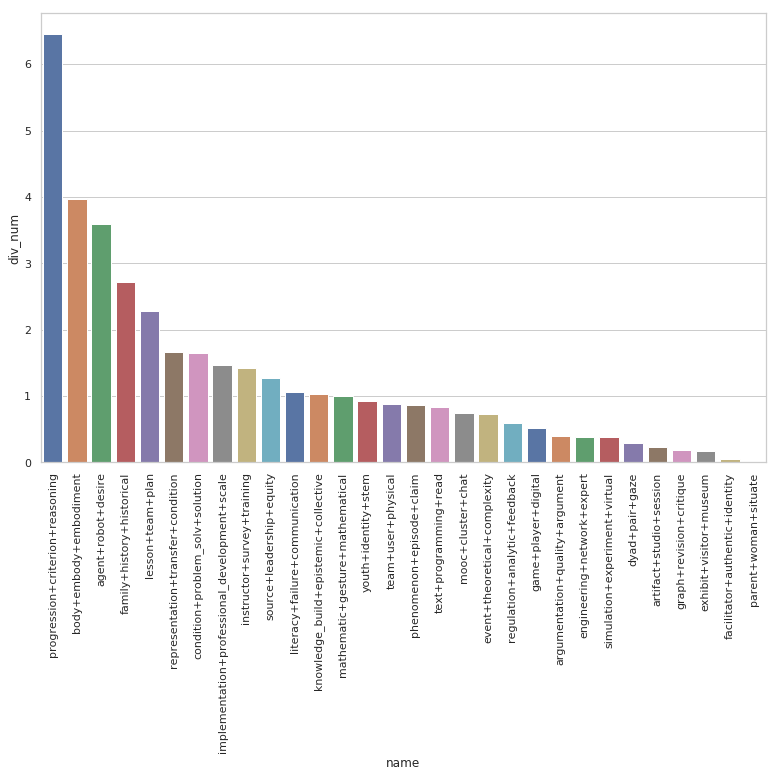

In [60]:
pd.set_option('display.max_colwidth', 50)

df =  df_MinSim_num.reset_index().merge(df_dominant_topic.merge(author_data[['title', 'id']].drop_duplicates(), left_on='Document_No', right_on='id'), on='title')
df['topic_label'] = df.Dominant_Topic.apply(lambda x: topic_labels[int(x)])
df.head()

df_topic_diversity = df[[ 'Dominant_Topic', 'div_num' ]].groupby(['Dominant_Topic']).mean().sort_values(by = 'div_num', ascending=False)
df_topic_diversity = df_topic_diversity.reset_index()
t = pd.DataFrame(topic_labels).reset_index()
t.columns = ['topic', 'name']
df_topic_diversity = df_topic_diversity.merge(t, left_on='Dominant_Topic', right_on='topic').drop('Dominant_Topic',axis = 1)[['topic', 'name','div_num']]
# Generate some sequential data
g =sns.barplot(x='name', y='div_num',data=df_topic_diversity, palette="deep")
g.set_xticklabels(df_topic_diversity.name, rotation=90)
plt.show()



We also plot the graph by div_ratio mean.

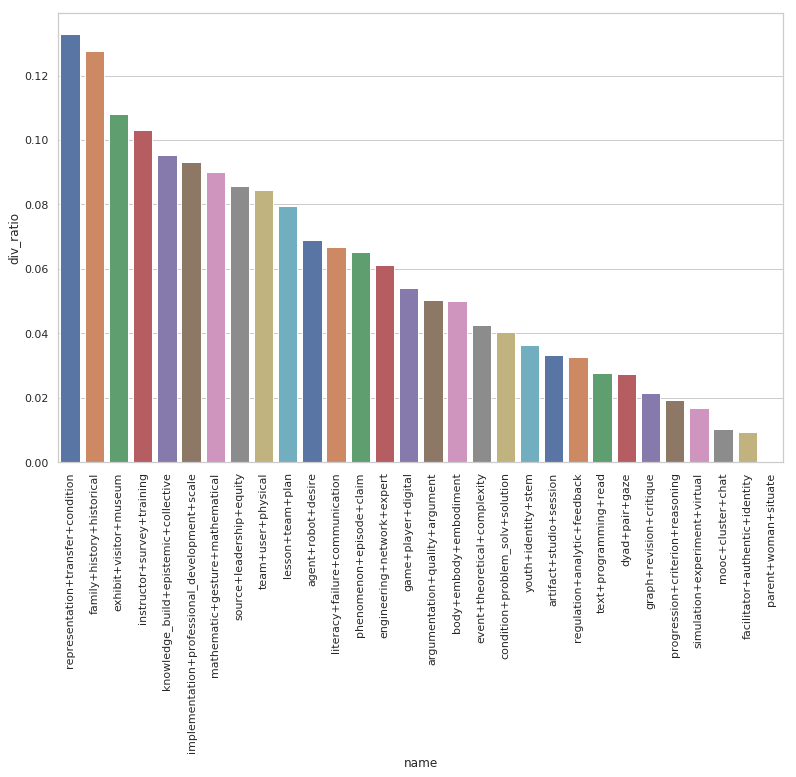

In [61]:
df_topic_diversity_ratio = df[[ 'Dominant_Topic', 'div_ratio' ]].groupby(['Dominant_Topic']).mean().sort_values(by = 'div_ratio', ascending=False)
df_topic_diversity_ratio = df_topic_diversity_ratio.reset_index()
t = pd.DataFrame(topic_labels).reset_index()
t.columns = ['topic', 'name']
df_topic_diversity_ratio = df_topic_diversity_ratio.merge(t, left_on='Dominant_Topic', right_on='topic').drop('Dominant_Topic',axis = 1)[['topic', 'name','div_ratio']]
# Generate some sequential data
g =sns.barplot(x='name', y='div_ratio',data=df_topic_diversity_ratio, palette="deep")
g.set_xticklabels(df_topic_diversity_ratio.name, rotation=90)
plt.show()

Professors with very different topics among their publications(base on one's publication, calculate how many topics he concern). The more docs an author has, the more topic_div he could have.


### Who is versatile?

It is common that a reseacher work in different area. But who works the most frequently? For all of a author's works, we calculate his `topic_div_score` on: number of topics they concern and divided by the total work number. The score reflect an author's preference on working in different direction. 

On the other hand, experts in some area would like to cooperate with statisticians. And statisticians could help them analyze data and give insights. Therefore, there might be a group of people in our database who usually work with ones in different area and they are likely to be data scientist.

In [62]:
author_topicDiv = author_data[['title', 'id', 'long_name']].merge(df_dominant_topic, left_on='id', right_on='Document_No' )\
                .groupby(['long_name']).Dominant_Topic.nunique().to_frame() 
author_topicDiv.columns = ['topic_div']
author_topicDiv = author_topicDiv.sort_values(by = 'topic_div', ascending=False)
author_topicDiv = author_topicDiv.merge(pd.DataFrame(author_data.groupby('long_name').agg('count').id), left_index=True, right_index=True)
author_topicDiv.columns = ['topic_div', 'doc_amount']
author_topicDiv['topic_div_score'] = author_topicDiv.topic_div/author_topicDiv.doc_amount
author_topicDiv[author_topicDiv.doc_amount>5].sort_values(by='topic_div_score', ascending=False).head(20)


,topic_div,doc_amount,topic_div_score
long_name,,,
"Hakkarainen, Kai",6,6,1.000000
"Sayre, Eleanor C.",6,6,1.000000
"Hmelo-Silver, Cindy E.",7,7,1.000000
"Borge, Marcela",7,8,0.875000
"Hovey, Christopher M",6,7,0.857143
"Penuel, William R.",6,7,0.857143
"Basu, Satabdi",5,6,0.833333
"Dornfeld, Catherine",5,6,0.833333
"Svihla, Vanessa",5,6,0.833333


### Who likes to work with different guys?

For each paper written by prof X, calculate the max diversity between prof X and any other co-author and generate an average of these scores. In this case, `sim_ave`, known as similarity average, closed to 0.5 means prof X tend to work with distinct author each time.

In [63]:
#for each paper written by prof X, 
#calculate the max diversity between prof X and any other co-author, 
#and generate an average of these scores
def doit(title, name):
    t = author_data[author_data.title==title]
    t = t[t.long_name!=name]
    min_sim = 1
    for au in t.long_name:
        if sim_all.at[name,au] <=min_sim:
                min_sim = sim_all.at[name,au]
    return min_sim

def cal_sim_sum(au):
    for i in range(len(au)-1):
        title = au.title.values[i]
        name =au.long_name.values[i]
        t = author_data[author_data.title==title]
        t = t[t.long_name!=name]
        min_sim = 1
        for name2 in t.long_name:
            if sim_all.at[name,name2] <=min_sim:
                    min_sim = sim_all.at[name,name2]
        author_sim_sum.at[name,'sim_sum'] += min_sim
        author_sim_sum.at[name,'doc_amount'] += 1

author_sim_sum = pd.DataFrame(np.zeros(shape=(len(author2doc),2)))
author_sim_sum.columns=['sim_sum', 'doc_amount']
author_sim_sum.index=author_data.long_name.unique()

pd.DataFrame(author_data.groupby(['long_name']).apply(cal_sim_sum))
author_sim_sum['sim_ave'] = author_sim_sum['sim_sum']/author_sim_sum['doc_amount']
author_sim_sum[author_sim_sum.doc_amount>3].sort_values(by='sim_ave').head(20)


,sim_sum,doc_amount,sim_ave
"Bielaczyc, Katerine",2.001836,4.0,0.500459
"Tissenbaum, Mike",2.512396,5.0,0.502479
"Jona, Kemi",2.034586,4.0,0.508647
"Hmelo-Silver, Cindy E.",3.058260,6.0,0.509710
"Hakkarainen, Kai",2.552561,5.0,0.510512
"Thompson, Kate",2.042869,4.0,0.510717
"Silver, Cindy Hmelo",2.044311,4.0,0.511078
"Brady, Corey",2.051090,4.0,0.512772
"Clarke, Sherice",2.076963,4.0,0.519241
"Hoppe, H. Ulrich",2.080009,4.0,0.520002


This plot takes prof X's work times as a whole and count the cross work ratio.

In [65]:
# Diversity per professor based on co-authors
def cal_coauth_times(au):
    min_nu = 0
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
            au1 = au.long_name.values[i]
            au2 = au.long_name.values[j]
            if sim_all.at[au1,au2] <=0.51:
                coauthor_time.at[au1,au2] += 1
                coauthor_time.at[au2,au1] += 1

coauthor_time = pd.DataFrame(np.zeros(shape=(len(author2doc),len(author2doc))))
coauthor_time.columns=author_data.long_name.unique()
coauthor_time.index=author_data.long_name.unique()

pd.DataFrame(author_data.groupby(['title']).apply(cal_coauth_times))
df_coauthor_time = coauthor_time.sum(axis=0).to_frame()
df_coauthor_time.columns = ['cross_work_times']

t = pd.DataFrame(co_auth.sum(axis=0))
t.columns = ['all_work_times']

df_cross_work = df_coauthor_time.sort_values(by='cross_work_times', ascending =False).merge(t,left_index=True, right_index=True)
df_cross_work = df_cross_work.reset_index()
df_cross_work.columns = ['name', 'cross_work_times', 'all_work_times']
df_cross_work['ratio'] = df_cross_work.cross_work_times/df_cross_work.all_work_times

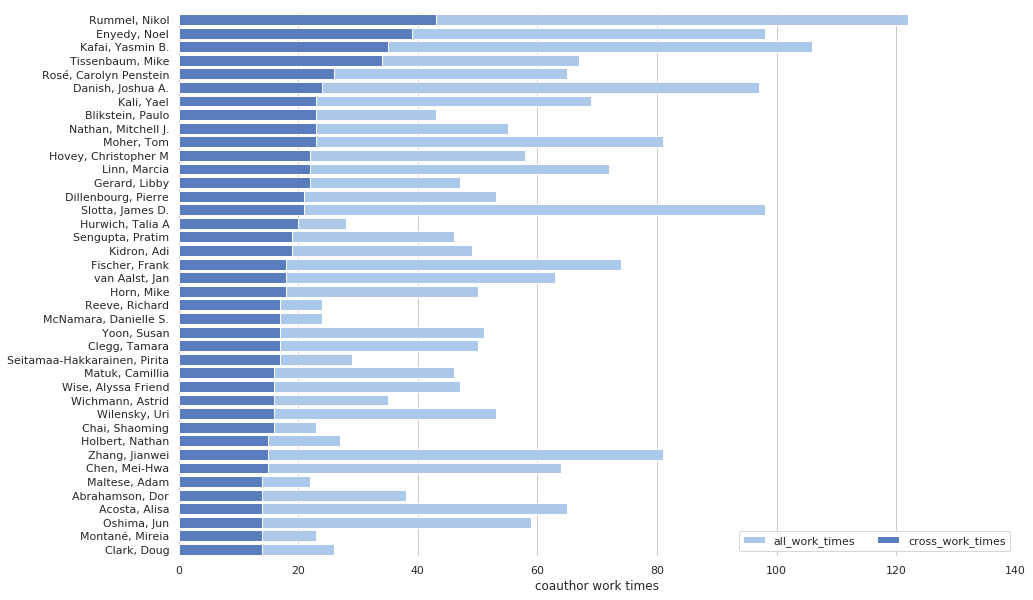

In [66]:

interest_number = 40
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_work_times", y="name", data=df_cross_work.head(interest_number),
            label="all_work_times", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="cross_work_times", y="name", data=df_cross_work.head(interest_number),
            label="cross_work_times", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 140), ylabel="",
       xlabel="coauthor work times")
sns.despine(left=True, bottom=True)

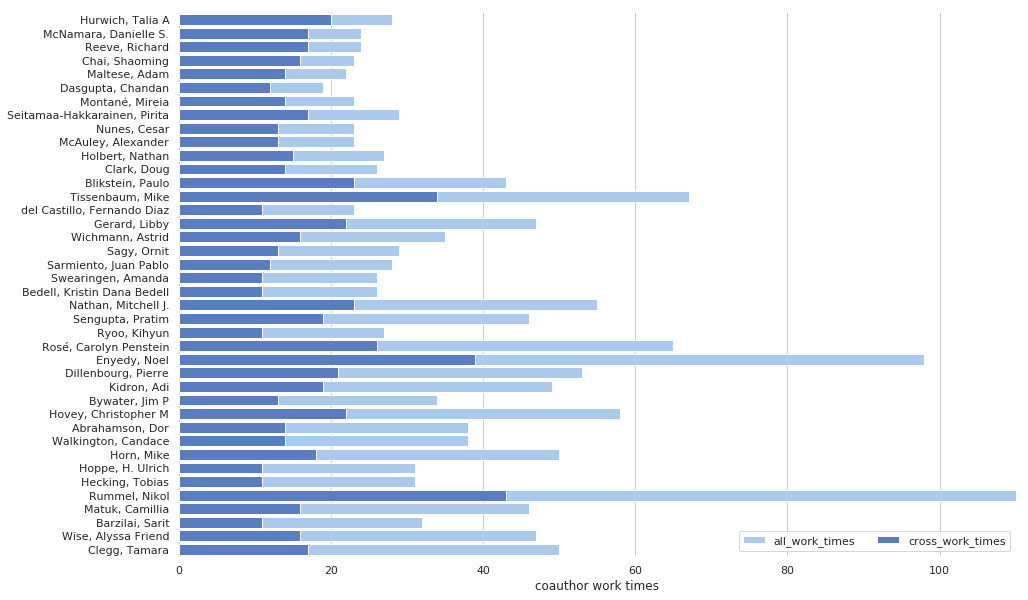

In [67]:
interest_number = 40
data = df_cross_work[df_cross_work.cross_work_times>10].sort_values(by='ratio', ascending=False)
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_work_times", y="name", data=data.head(interest_number),
            label="all_work_times", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="cross_work_times", y="name", data=data.head(interest_number),
            label="cross_work_times", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 110), ylabel="",
       xlabel="coauthor work times")
sns.despine(left=True, bottom=True)

Relationships between topics - are certain topics likely to co-occur?
create a network, where each node is a topic. 
for each paper, create authorship pairs, so for example A, B, C co-authors, pairs are A-B, A-c and B-C.
For each co-authorship pair where A is in node 5 and B is in node 6, add 1 to the weight of the link between node 5 and node 6 in the graph
look at which nodes are clustered together... 


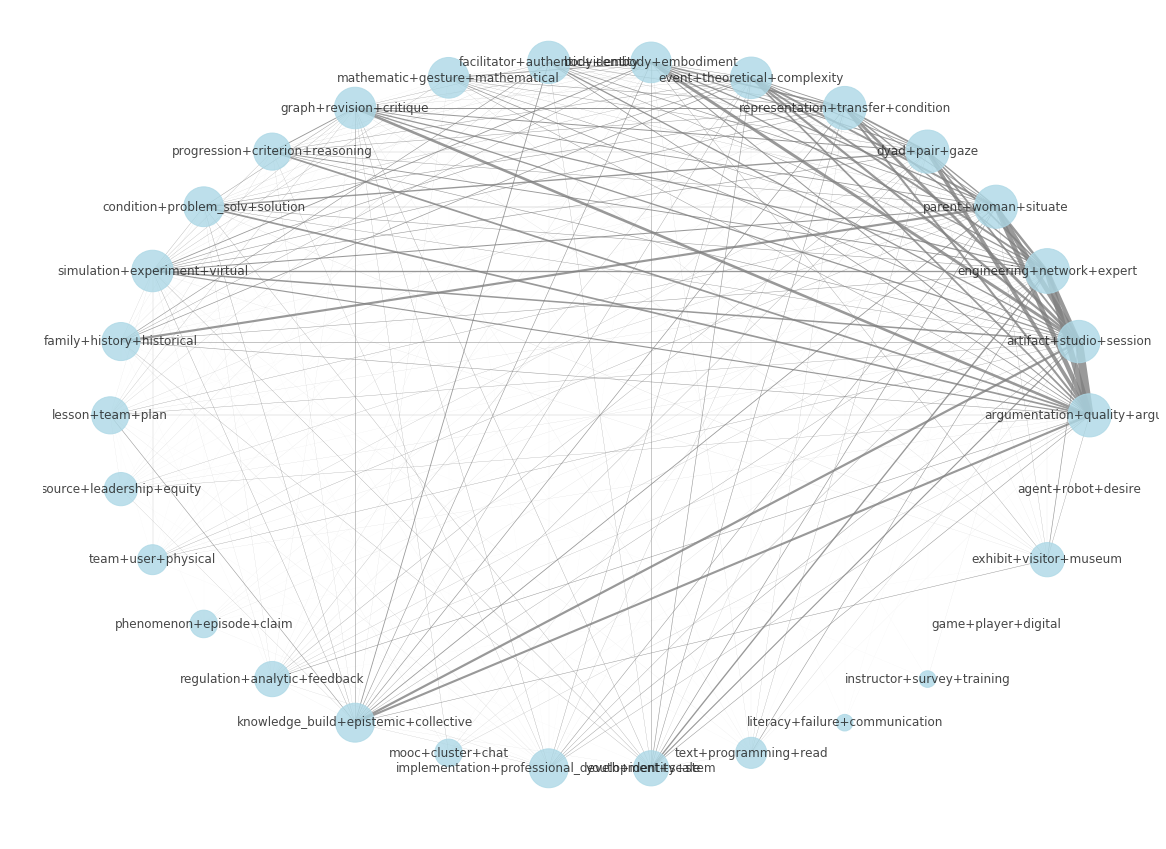

In [68]:
G = nx.graph
def cal_topicWeight(au):
    min_nu = 0
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
            au1 = au.long_name.values[i]
            au2 = au.long_name.values[j]
            tpc1 = topic_labels[model[au1][0][0]]
            tpc2 = topic_labels[model[au2][0][0]]
            weight_topic.at[tpc1,tpc2] += 1
            weight_topic.at[tpc2,tpc1] += 1

weight_topic = pd.DataFrame(np.zeros(shape=(optimal_topic_num,optimal_topic_num)))
weight_topic.columns=topic_labels
weight_topic.index=topic_labels

author_data.groupby(['title']).apply(cal_topicWeight)
G = nx.from_pandas_adjacency(weight_topic)

node_size = (np.array(list(nx.degree_centrality(G).values())))*2000
edge_color= np.array(list(nx.get_edge_attributes(G, 'weight').values()))
palette = sns.color_palette(palette='Set1', n_colors=2)
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20, 15), frameon=False)
pos = nx.layout.shell_layout(G, scale=0.5)

plt.axis('off')
nx.draw(G, pos=pos, edge_color='grey', width = edge_color/50, 
        edge_cmap = plt.cm.gray_r, alpha=0.8, 
        cmap=ListedColormap(palette.as_hex()), 
        node_size=node_size, 
        with_labels=True, 
        node_color='#add8e6')
                
# plt.savefig('figures/country_collab')
plt.show()